In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
plt.style.use('Solarize_Light2')
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan
import math


mpl.rcParams['figure.dpi'] = 150


In [3]:
blobs, labels = make_blobs(n_samples=2000, n_features=10) # 10 features
pd.DataFrame(blobs).head() # show the first 5 rows

clusterer = hdbscan.HDBSCAN()

def healpix(sourceID, level):
    pixel = math.floor(sourceID /(2**35 * 4**(12-level)))
    return pixel

def parallax(mas):
    arcsec = mas/1000
    return 1/arcsec


parallax(1.1)

healpix(3094113406614578432, 5)


5496

In [4]:
clusterer.fit(blobs) # do the clustering algorithm

#clusterer stores the results of the clusters in the labels_ attribute

clusterer.labels_ # show the labels of the clusters
# This gives an array of integers, where each integer is the cluster number of the corresponding row in the input data

cluster_amount = clusterer.labels_.max() +1 # number of clusters

cluster_amount
#data samples that are not assigned to a cluster get label -1   



3

In [5]:
membership_score = clusterer.probabilities_ # membership score of each data point to the cluster it is assigned to ranging from 0 to 1. 
# A score of 0.0 represents a sample that is not in the cluster at all (all noise points will get this score)
# while a score of 1.0 represents a sample that is at the heart of the cluster (note that this is not the spatial centroid notion of core).

membership_score

array([0.69062661, 0.70984315, 0.75826924, ..., 0.64906692, 0.44755839,
       0.89838651])

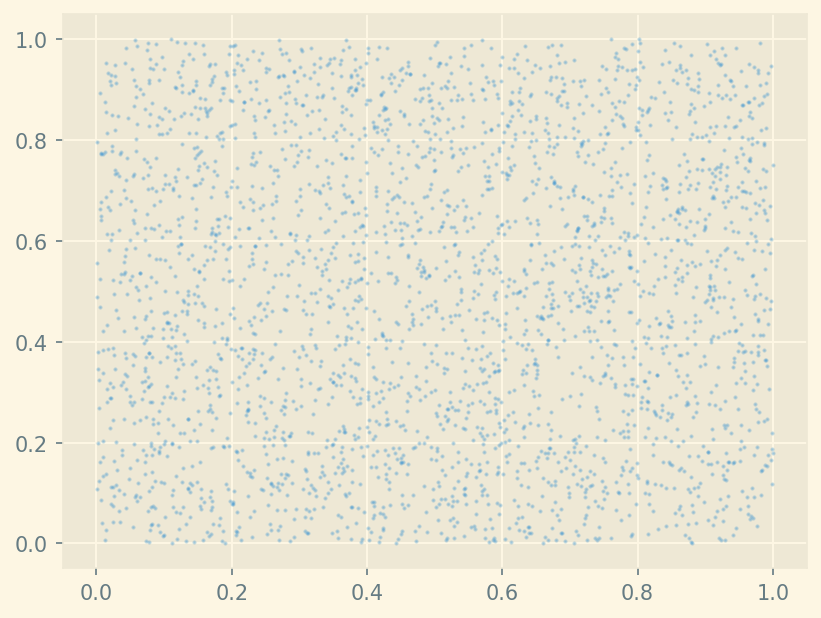

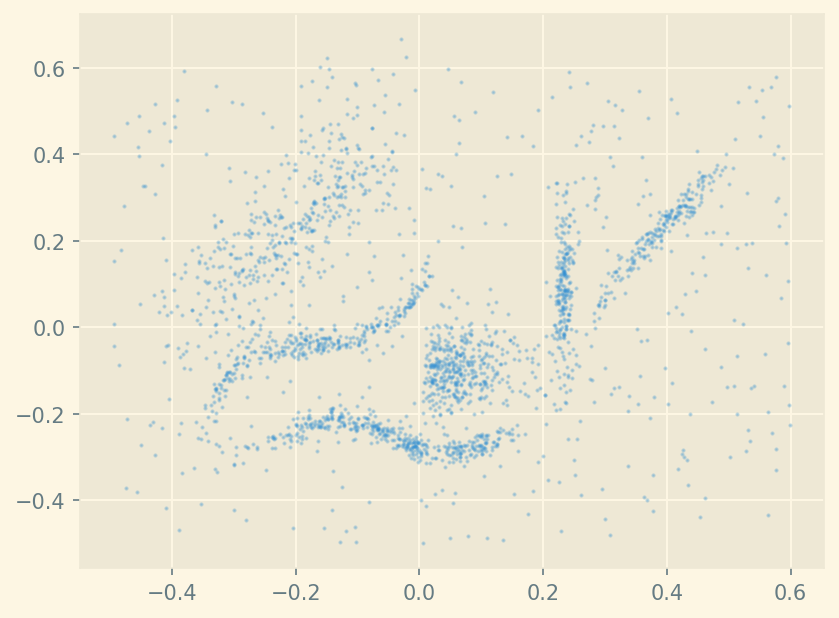

In [6]:
#//generate 3000 random datapoints in 2d

data = np.load('Data\\clusterable_data.npy')
randomdata = np.random.rand(3000,2)
plt.plot(randomdata[:,0], randomdata[:,1], 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()

plt.plot(*data.T, 'o', markersize=1, alpha=0.25, linewidth = 0)
plt.show()


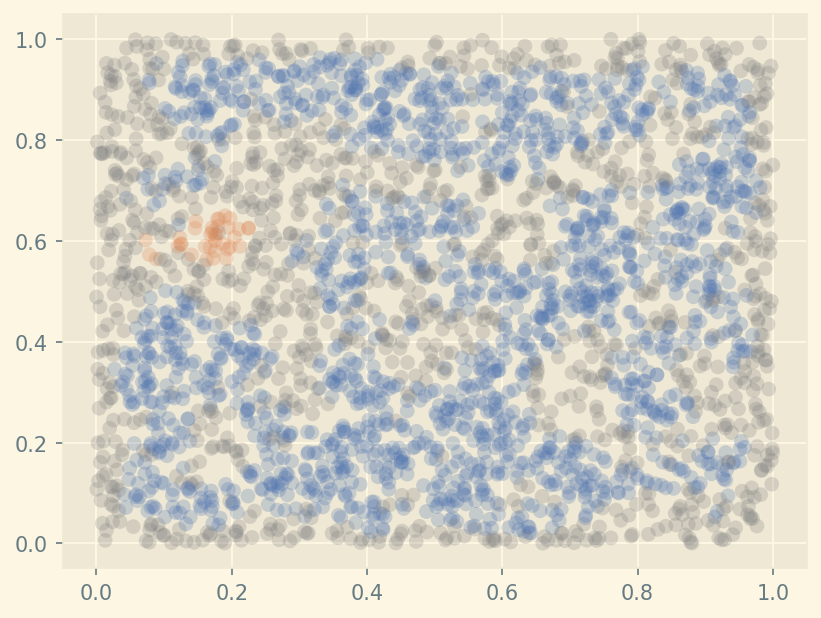

In [7]:

randclusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(randomdata)
color_palette = sns.color_palette('deep', 77)

cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in randclusterer.labels_]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, randclusterer.probabilities_)]

plt.scatter(randomdata[:,0], randomdata[:,1], s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)



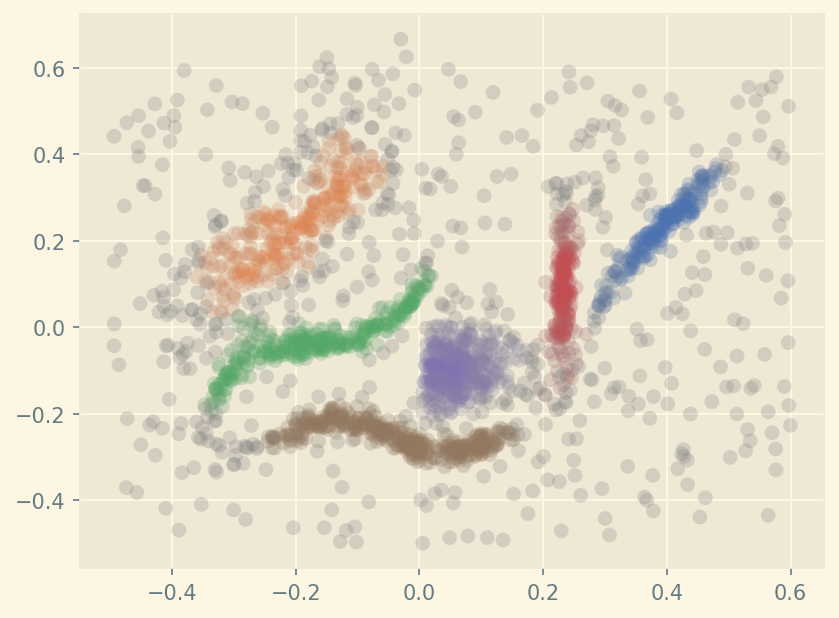

In [8]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

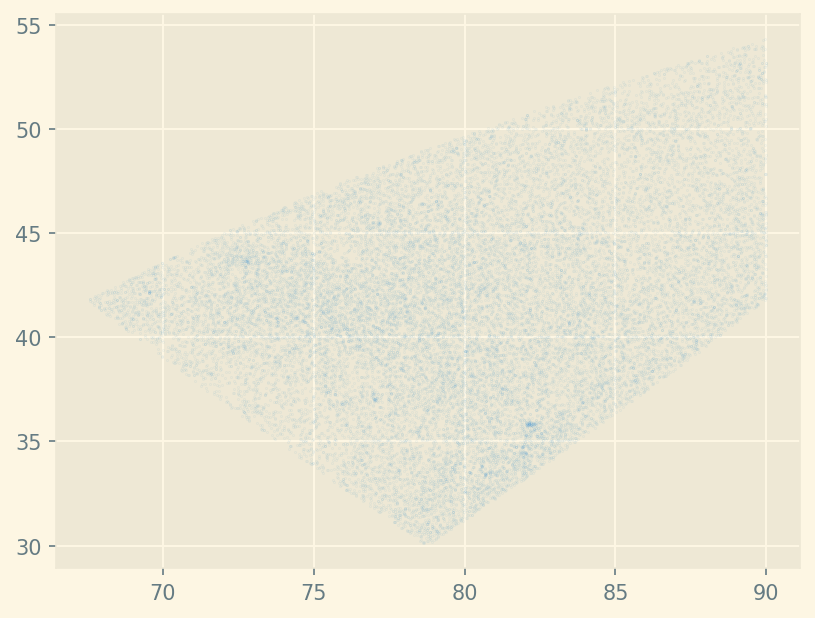

array(['COIN-Gaia_13', 'Platais_10', 'UBC_13', 'UBC_14', 'UBC_21',
       'UPK_495', 'UPK_533', 'UPK_654'], dtype=object)

In [9]:
coindata = pd.read_csv('Data\\COIN_results.csv')

members = pd.read_csv('Data\\inner_members.csv')
                                                
coindata = coindata[coindata['phot_g_mean_mag'] <= 12]
 
plt.plot(coindata['ra'], coindata['dec'], 'o', markersize=0.1, alpha=0.25, linewidth = 0)
plt.show()
members['Cluster'].unique()

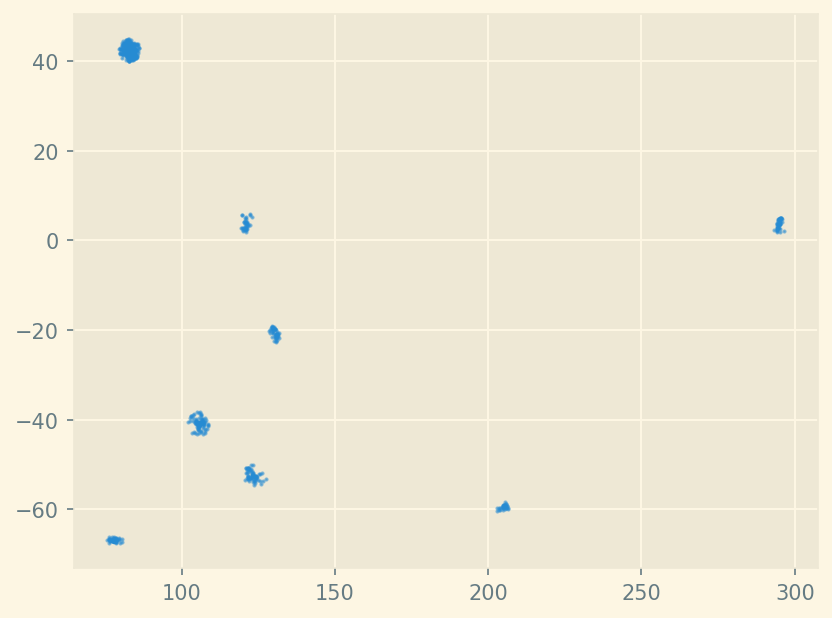

In [10]:

COINmembers = members[members['Cluster'] == 'COIN-Gaia_13']

plt.scatter(members['RAdeg'], members['DEdeg'],marker= 'o', s=1, alpha=0.5)
plt.show()

clusters = members['Cluster'].unique()


In [11]:
coinneeded = coindata[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]
coinneeded = coinneeded.dropna()

coinclusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method='leaf', min_samples=10).fit(coinneeded)

print(coinclusterer.labels_.max() + 1)



43


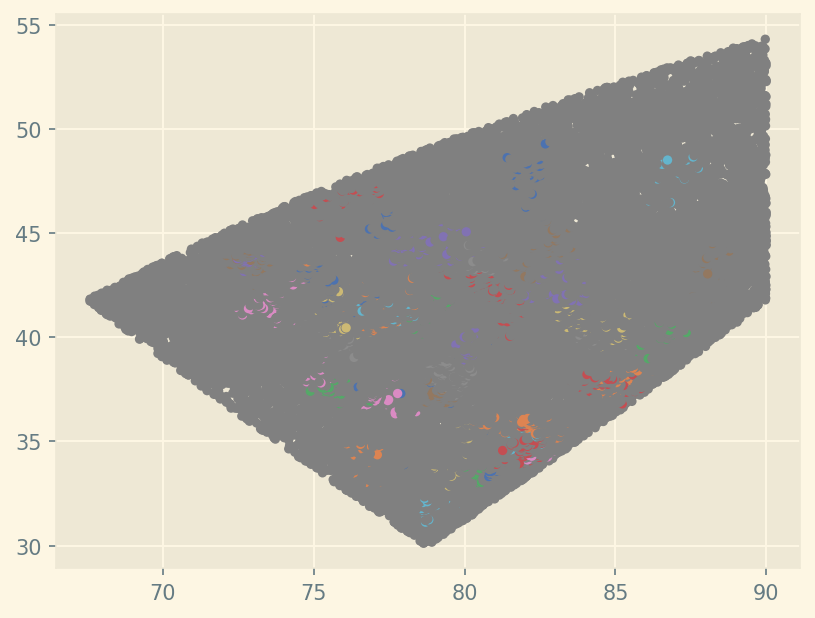

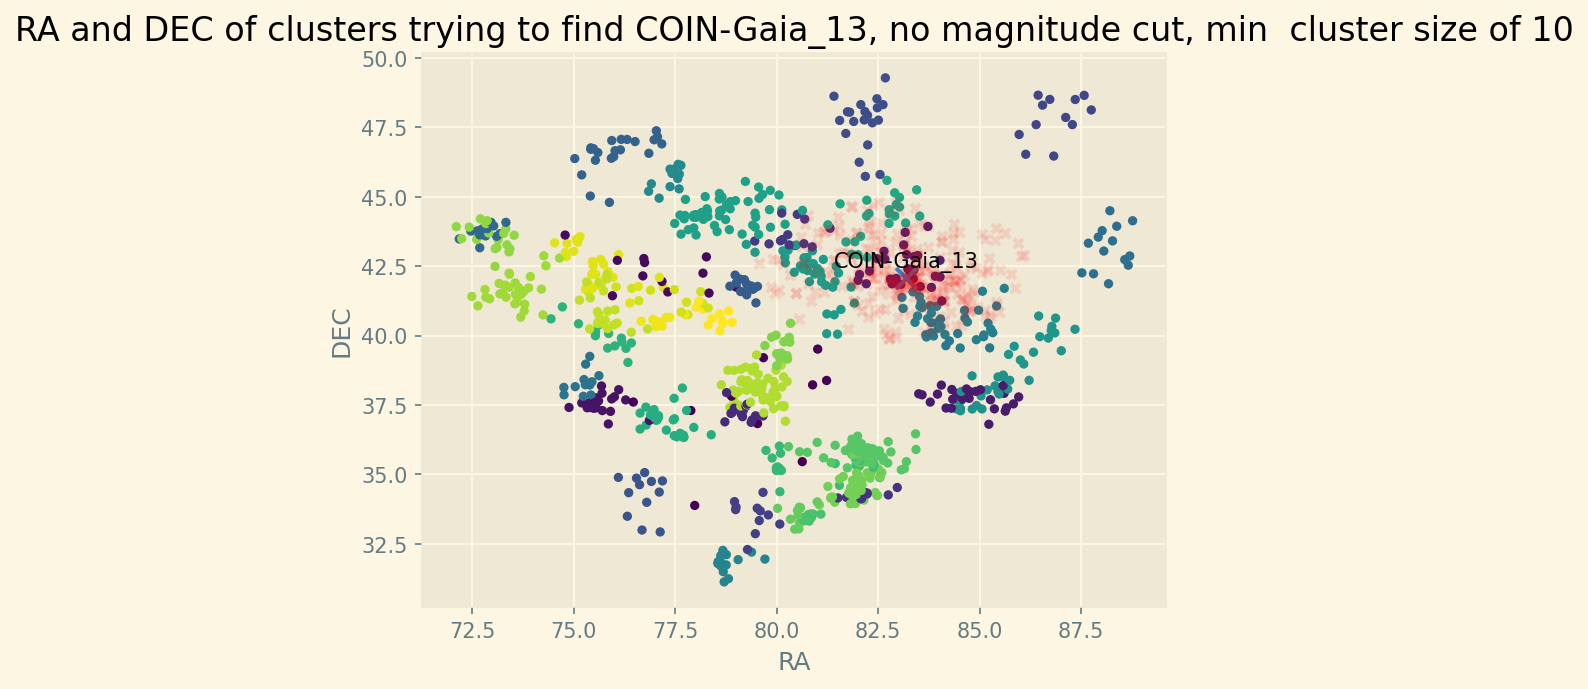

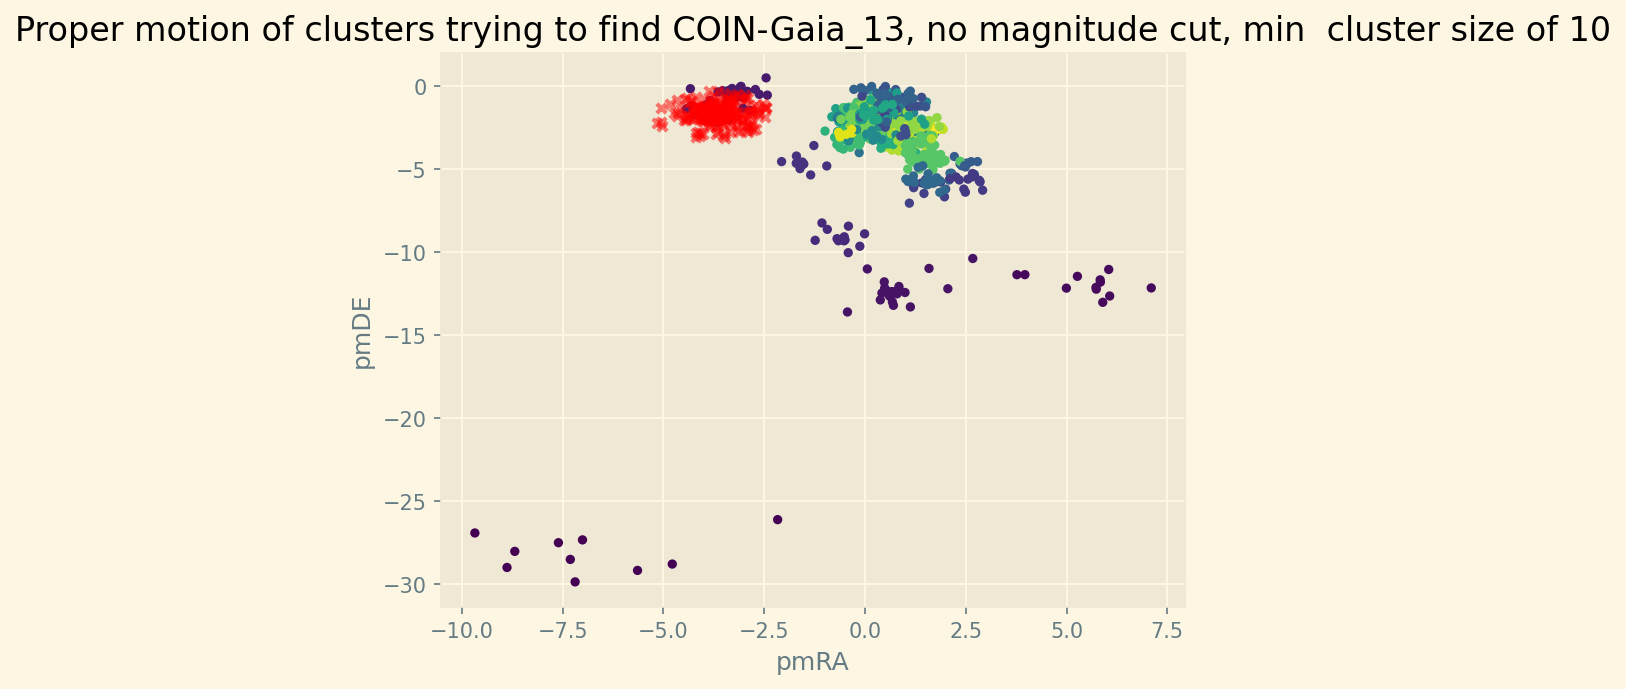

In [12]:
indices_to_keep = np.where(coinclusterer.labels_ != -1)[0]
filtered_df = coinneeded.iloc[indices_to_keep]


color_palette = sns.color_palette('deep', coinclusterer.labels_.max() + 1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in coinclusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, coinclusterer.probabilities_)]
plt.scatter(coinneeded['ra'], coinneeded['dec'], s=20, linewidth=0, c=cluster_colors )
plt.show()

plt.scatter(filtered_df['ra'], filtered_df['dec'], s=20, linewidth=0, c=coinclusterer.labels_[indices_to_keep] )
plt.scatter(83.186, 42.087, marker = 'x', s = 100)
plt.annotate('COIN-Gaia_13', (83.186, 42.087), textcoords="offset points", xytext=(0,5), ha='center')
plt.scatter(COINmembers['RAdeg'], COINmembers['DEdeg'],marker= 'x', s=20, c='red', alpha=0.1)
plt.title('RA and DEC of clusters trying to find COIN-Gaia_13, no magnitude cut, min  cluster size of 10')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.savefig('Data\\COINclusters.pdf')
plt.show()

plt.scatter(filtered_df['pmra'], filtered_df['pmdec'], s=20, linewidth=0, c=coinclusterer.labels_[indices_to_keep] )
plt.scatter(COINmembers['pmRA'], COINmembers['pmDE'],marker= 'x', s=20, c='red', alpha=0.5)
plt.title('Proper motion of clusters trying to find COIN-Gaia_13, no magnitude cut, min  cluster size of 10')
plt.xlabel('pmRA')
plt.ylabel('pmDE')
plt.savefig('Data\\COINclustersPM.pdf')
plt.show()

In [13]:
coindata12 = coindata[coindata['phot_g_mean_mag'] <= 12]

coin12needed = coindata12[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']]
coin12needed = coin12needed.dropna()

coin12clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method='leaf', min_samples=10).fit(coindata12[['ra', 'dec', 'parallax', 'pmra', 'pmdec']].dropna())

print(coin12clusterer.labels_.max() + 1)

coin12needed['clusternumber'] = coin12clusterer.labels_

43


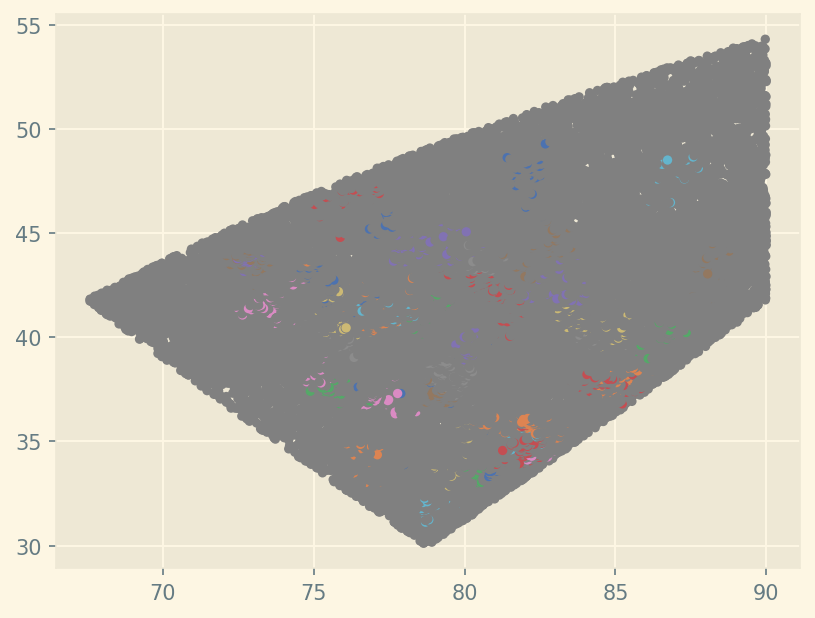

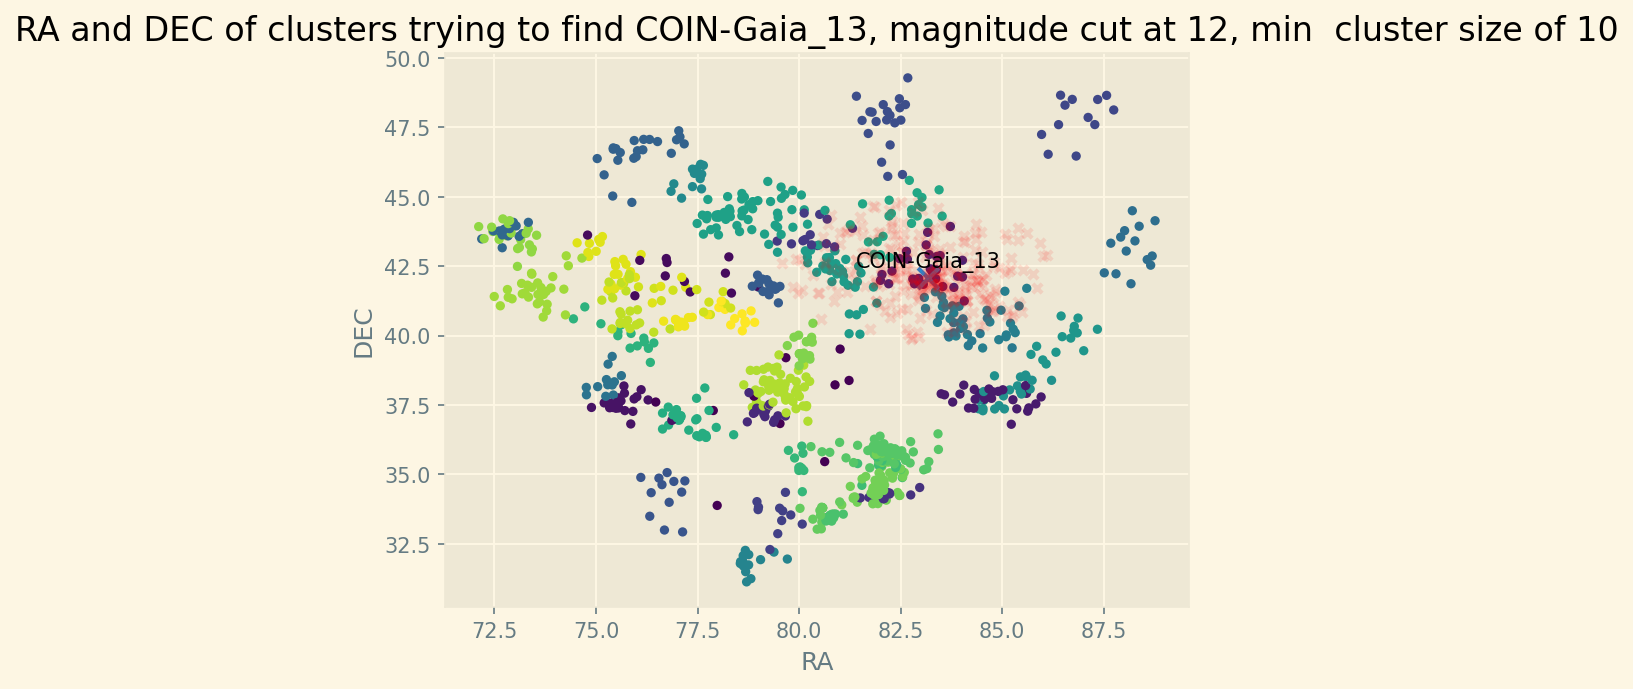

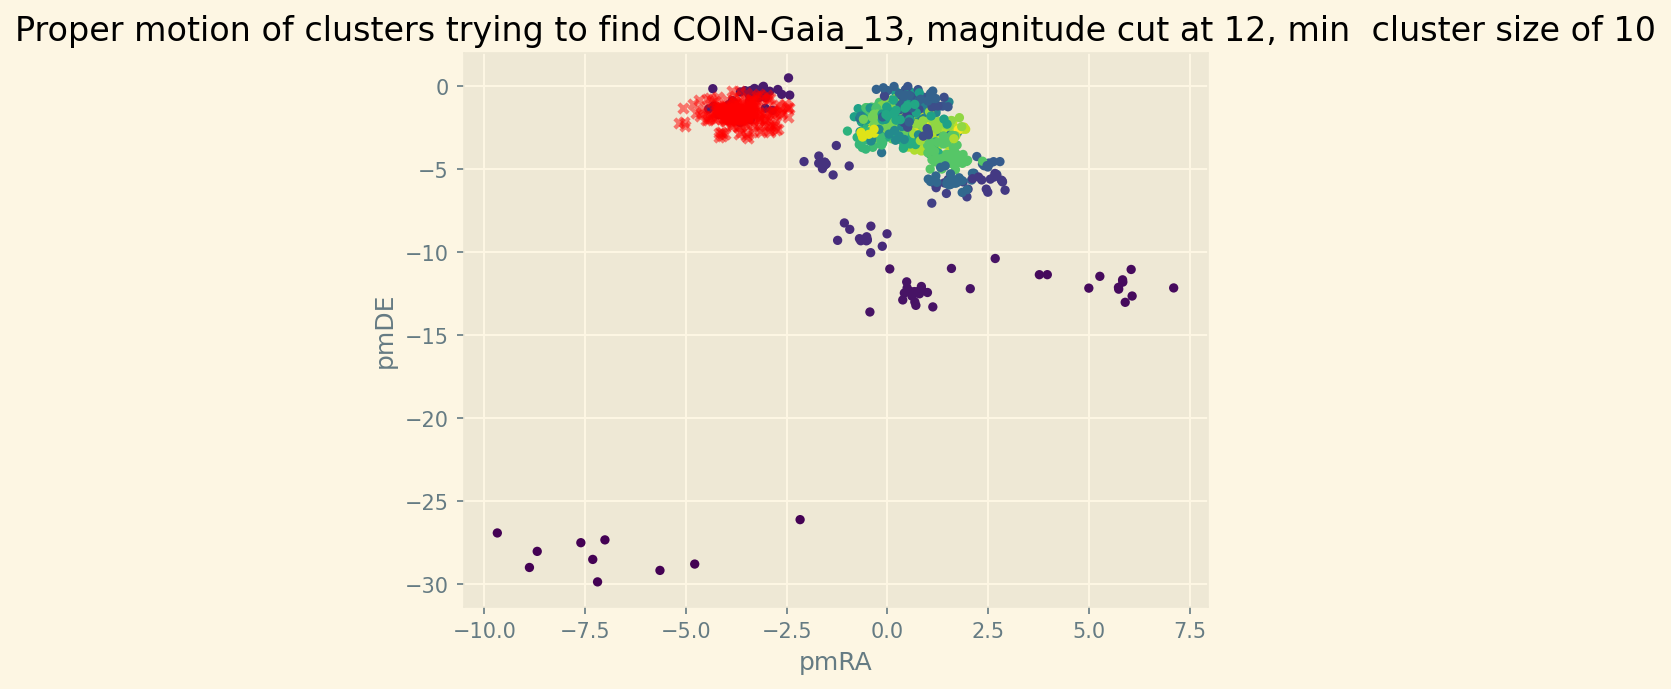

In [14]:
indices_to_keep = np.where(coin12clusterer.labels_ != -1)[0]
filtered_df = coin12needed.iloc[indices_to_keep]



color_palette = sns.color_palette('deep', coin12clusterer.labels_.max() + 1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in coin12clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, coin12clusterer.probabilities_)]
plt.scatter(coin12needed['ra'], coin12needed['dec'], s=20, linewidth=0, c=cluster_colors )
plt.show()

plt.scatter(filtered_df['ra'], filtered_df['dec'], s=20, linewidth=0, c=coin12clusterer.labels_[indices_to_keep] )
plt.scatter(83.186, 42.087, marker = 'x', s = 100)
plt.annotate('COIN-Gaia_13', (83.186, 42.087), textcoords="offset points", xytext=(0,5), ha='center')
plt.scatter(COINmembers['RAdeg'], COINmembers['DEdeg'],marker= 'x', s=20, c='red', alpha=0.1)
plt.title('RA and DEC of clusters trying to find COIN-Gaia_13, magnitude cut at 12, min  cluster size of 10')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.savefig('Data\\COINclusters12.pdf')
plt.show()


plt.scatter(filtered_df['pmra'], filtered_df['pmdec'], s=20, linewidth=0, c=coin12clusterer.labels_[indices_to_keep] )
plt.scatter(COINmembers['pmRA'], COINmembers['pmDE'],marker= 'x', s=20, c='red', alpha=0.5)
plt.title('Proper motion of clusters trying to find COIN-Gaia_13, magnitude cut at 12, min  cluster size of 10')
plt.xlabel('pmRA')
plt.ylabel('pmDE')
plt.savefig('Data\\COINclustersPM12.pdf')
plt.show()


RAdeg      DEdeg              Source        GLON      GLAT  \
0   83.538520  41.767290  194440939089313024  167.870844  4.824743   
1   83.059241  41.846069  194452758839385600  167.610645  4.566699   
2   83.811764  41.736007  194412798463867904  168.007181  4.979925   
3   83.364926  42.049391  194461245694646912  167.562483  4.867906   
4   83.905895  42.139526  194472343886892416  167.702507  5.254958   
5   84.024228  42.112825  194474229379139584  167.772228  5.314921   
6   82.844194  41.863932  194549996899936384  167.508277  4.441958   
7   82.207185  41.866444  194582535571901312  167.245737  4.046353   
8   82.005075  41.989508  194600952391328256  167.059707  3.988752   
9   82.945542  42.058430  194657882180364544  167.385680  4.610993   
10  83.231515  42.405050  194713235718861440  167.208473  4.976776   
11  83.276226  42.307285  194667713362828800  167.308971  4.951770   
12  83.474572  42.882333  194743888902561536  166.901534  5.384600   
13  84.068536  41.248125  191362821927723776  168.524214  4.881578   
14  82.288551  42.322334  195380471776559360  166.897214  4.347457   
15  82.668426  42.751567  195407684689059840  166.690494  4.816635   
16  82.041448  42.199497  195356007642995072  166.899098  4.127163   
17  82.480630  42.767859  195410708346087168  166.601234  4.710033   
18  83.203338  42.921105  195494649186878208  166.761222  5.238107   
19  82.644525  43.035745  195464614477517824  166.441823  4.956903   
20  83.130008  43.266187  195564639973819392  166.440518  5.379453   
21  83.725949  43.930640  195615148788814464  166.110168  6.100361   
22  83.166198  43.717826  195776295962108416  166.072834  5.645390   

    parallax_x     e_Plx      pmRA    e_pmRA      pmDE  ...     BP-RP  Proba  \
0     1.626288  0.054582 -4.270915  0.083025 -1.998807  ...  0.253371   0.92   
1     2.357356  0.069815 -3.514104  0.096067 -2.311318  ...  0.230180   0.34   
2     1.823844  0.050545 -3.764823  0.109135 -1.118446  ...  0.086513   0.41   
3     1.934917  0.039989 -3.963403  0.068597 -1.420282  ...  0.653546   0.72   
4     1.916014  0.049051 -3.514469  0.085850 -1.653022  ...  0.478699   0.76   
5     1.695219  0.074584 -3.908410  0.110046 -2.064497  ...  0.025147   0.92   
6     2.072342  0.070128 -3.936024  0.104891 -1.490274  ...  0.210335   0.68   
7     1.896318  0.067884 -3.763876  0.112329 -1.807073  ...  0.243883   0.97   
8     1.813917  0.049671 -3.629921  0.079678 -1.694461  ...  0.399233   0.97   
9     1.790065  0.068013 -3.934066  0.104301 -1.886877  ...  0.345162   0.99   
10    1.976429  0.044567 -3.796817  0.082973 -1.570192  ...  0.642358   1.00   
11    1.722561  0.062337 -4.152135  0.137602 -1.420939  ...  0.263021   0.46   
12    1.968423  0.053879 -3.969997  0.090545 -1.840854  ...  0.324176   1.00   
13    1.903407  0.045628 -3.462349  0.073641 -2.015800  ...  0.456869   0.69   
14    1.967820  0.057649 -3.841931  0.079249 -1.554725  ...  0.476177   0.94   
15    1.747868  0.058056 -3.792823  0.107605 -1.618255  ...  0.092271   0.93   
16    1.824589  0.062268 -3.708157  0.098658 -1.878031  ...  0.368451   0.99   
17    1.905523  0.037776 -3.661477  0.070307 -1.454619  ...  0.487293   0.95   
18    2.035401  0.058118 -3.377408  0.079507 -1.041230  ...  1.292979   0.27   
19    1.765446  0.042587 -3.780492  0.072352 -1.551096  ...  0.599564   0.96   
20    2.085669  0.042467 -4.004316  0.080859 -1.261652  ...  0.757481   0.44   
21    2.042115  0.049067 -2.622185  0.069465 -1.660779  ...  0.904023   0.09   
22    1.856436  0.071556 -4.117616  0.113909 -1.538940  ...  0.044411   0.53   

         Cluster         ra        dec  parallax_y      pmra     pmdec  \
0   COIN-Gaia_13  83.538520  41.767290    1.921250 -4.027664 -1.682868   
1   COIN-Gaia_13  83.059240  41.846068    2.633602 -3.656344 -2.211098   
2   COIN-Gaia_13  83.811763  41.736006    2.009353 -3.843775 -0.894901   
3   COIN-Gaia_13  83.364925  42.049391    1.999436 -4.047684 -1.472801   
4   COIN-Gaia_13  83.905895  42.1395

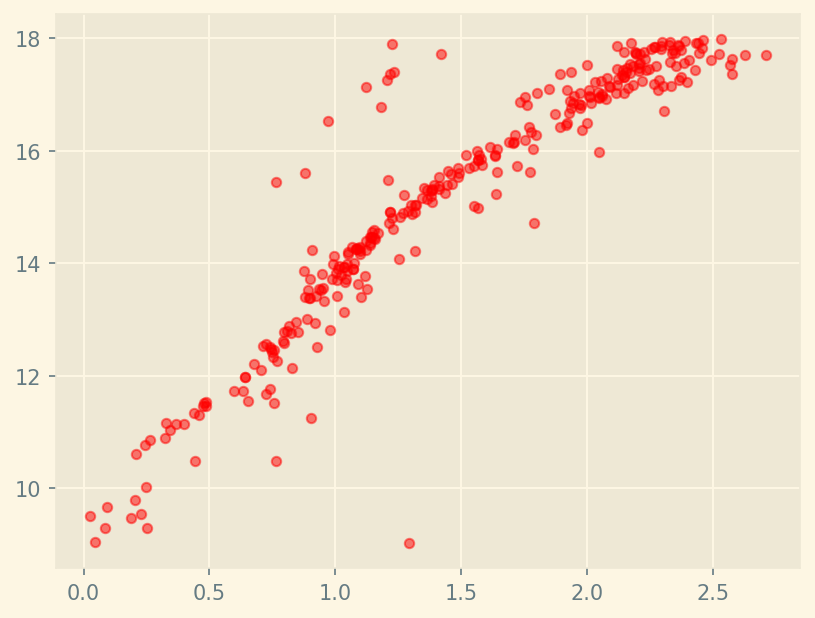

In [15]:


plt.scatter(COINmembers['BP-RP'], COINmembers['Gmag'], s=20, c='red', alpha=0.5)

merged = pd.merge(COINmembers, filtered_df, left_on='Source', right_on='source_id', how='inner')
# COINmembers.columns
# merged.query('phot_g_mean_mag <= 12')

merged

' so we find an overdensity which kind of corresponds with the cluster. how many conbtaminants do we find? change the magnitude limit, and see how it changes. \nmore faint in magnitude, more diluted cluster, see at different magnitude to how many clusters the cluster is assigned to.\nargument as completeness, purity and contamination. see if the purity of the cluster depends on density of stars (stars / square degree) i.e. the magnitude of the stars.'

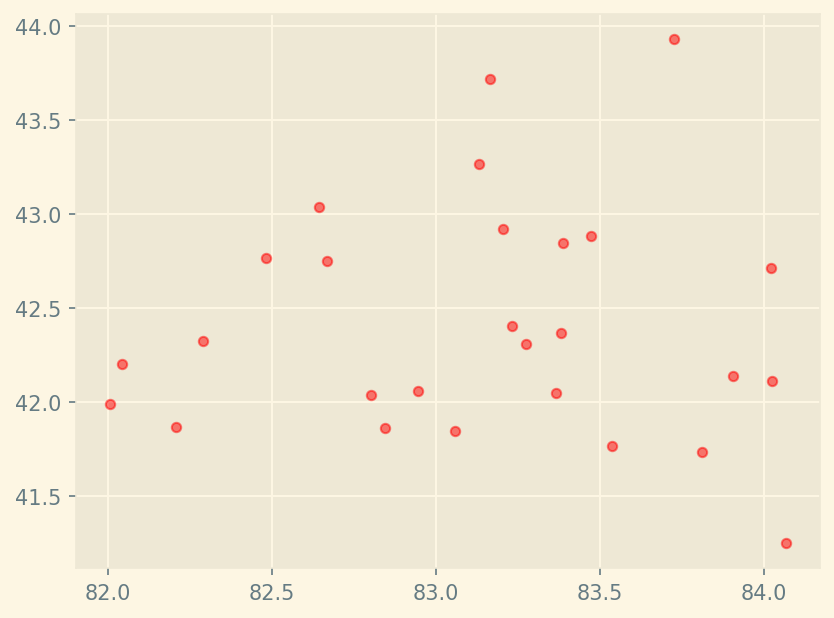

In [16]:
coincandidate = filtered_df.query('clusternumber ==4')
len(coincandidate)

plt.scatter(coincandidate['ra'], coincandidate['dec'], s=20, c='red', alpha=0.5)

#
''' so we find an overdensity which kind of corresponds with the cluster. how many conbtaminants do we find? change the magnitude limit, and see how it changes. 
more faint in magnitude, more diluted cluster, see at different magnitude to how many clusters the cluster is assigned to.
argument as completeness, purity and contamination. see if the purity of the cluster depends on density of stars (stars / square degree) i.e. the magnitude of the stars.'''

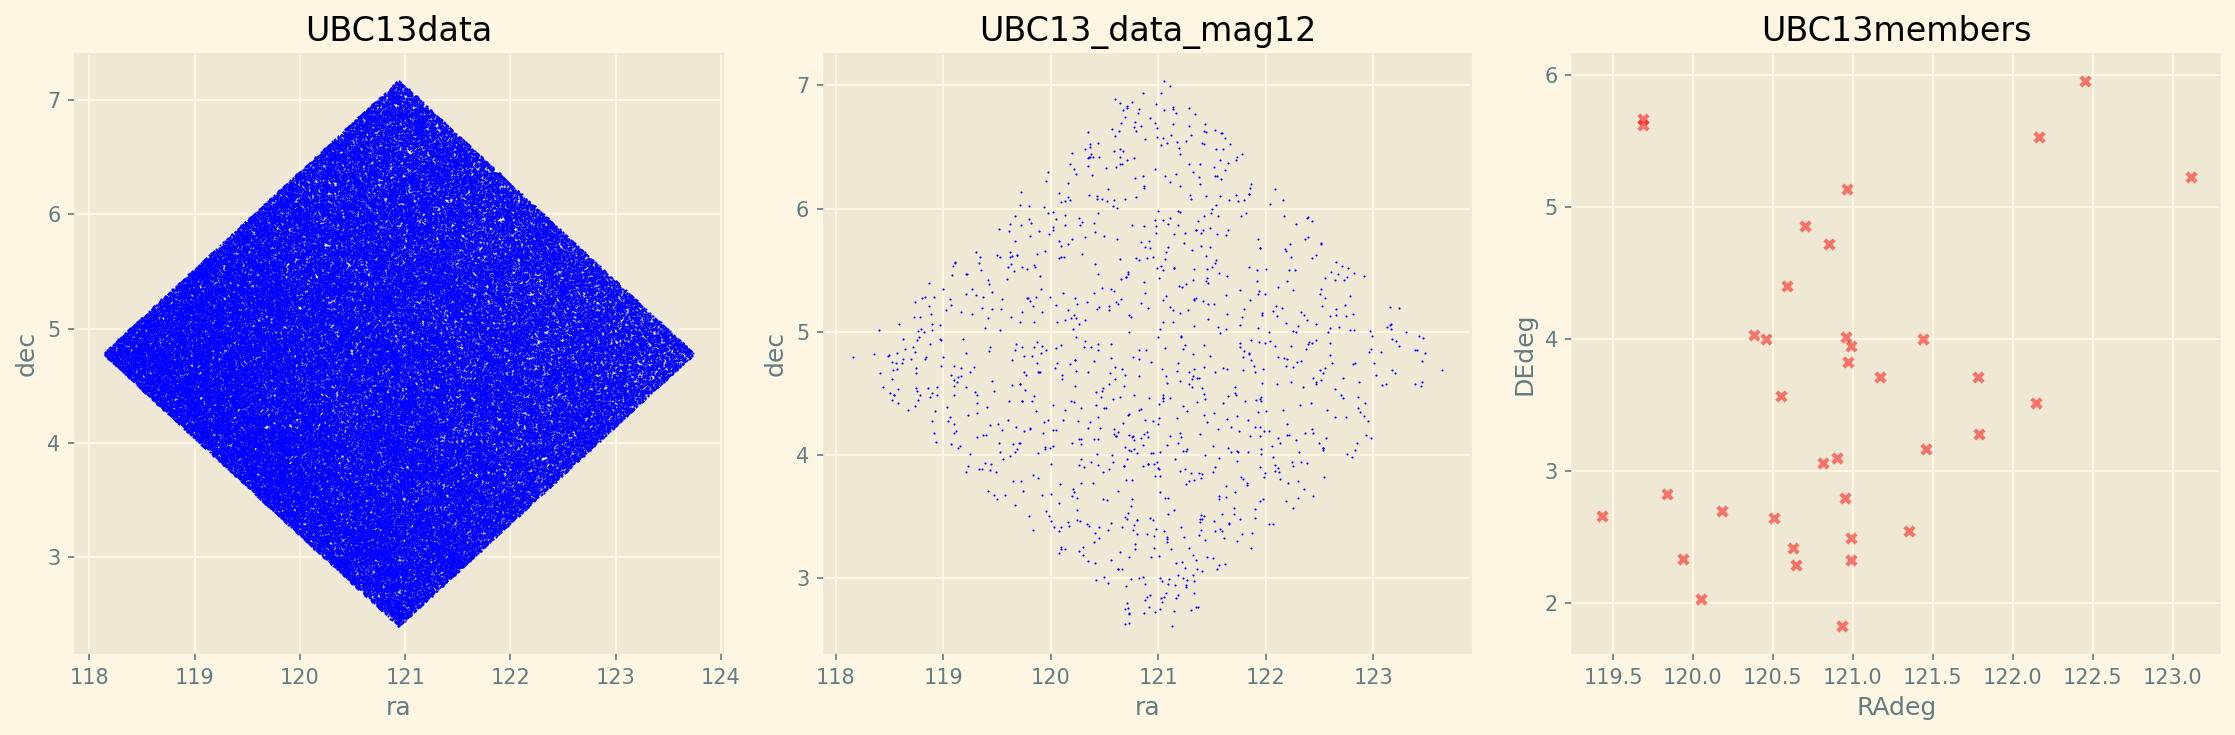

In [17]:
UBC13members = members[members['Cluster'] == 'UBC_13']
UBC13data = pd.read_csv('Data\\UBC13.csv')

UBC13_data_mag12 =UBC13data[UBC13data['phot_g_mean_mag'] <= 12]


fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].scatter(UBC13data['ra'], UBC13data['dec'], s=1, linewidth=0, c='blue')
axs[0].set_title('UBC13data')
axs[0].set_xlabel('ra')
axs[0].set_ylabel('dec')

# Second subplot
axs[1].scatter(UBC13_data_mag12['ra'], UBC13_data_mag12['dec'], s=1, linewidth=0, c='blue')
axs[1].set_title('UBC13_data_mag12')
axs[1].set_xlabel('ra')
axs[1].set_ylabel('dec')

# Third subplot
axs[2].scatter(UBC13members['RAdeg'], UBC13members['DEdeg'],marker= 'x', s=20, c='red', alpha=0.5)
axs[2].set_title('UBC13members')
axs[2].set_xlabel('RAdeg')
axs[2].set_ylabel('DEdeg')

plt.tight_layout()
plt.show()




In [18]:
#cluster the data
UBC13needed = UBC13_data_mag12[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']]
UBC13needed = UBC13needed.dropna()

UBC13_cluster_prep = UBC13needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]


UBC13_clusters_mag12 = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_method='leaf', min_samples=10).fit(UBC13_cluster_prep)

print(UBC13_clusters_mag12.labels_.max() + 1)

UBC13needed['clusternumber'] = UBC13_clusters_mag12.labels_ # add the cluster number to the dataframe


2


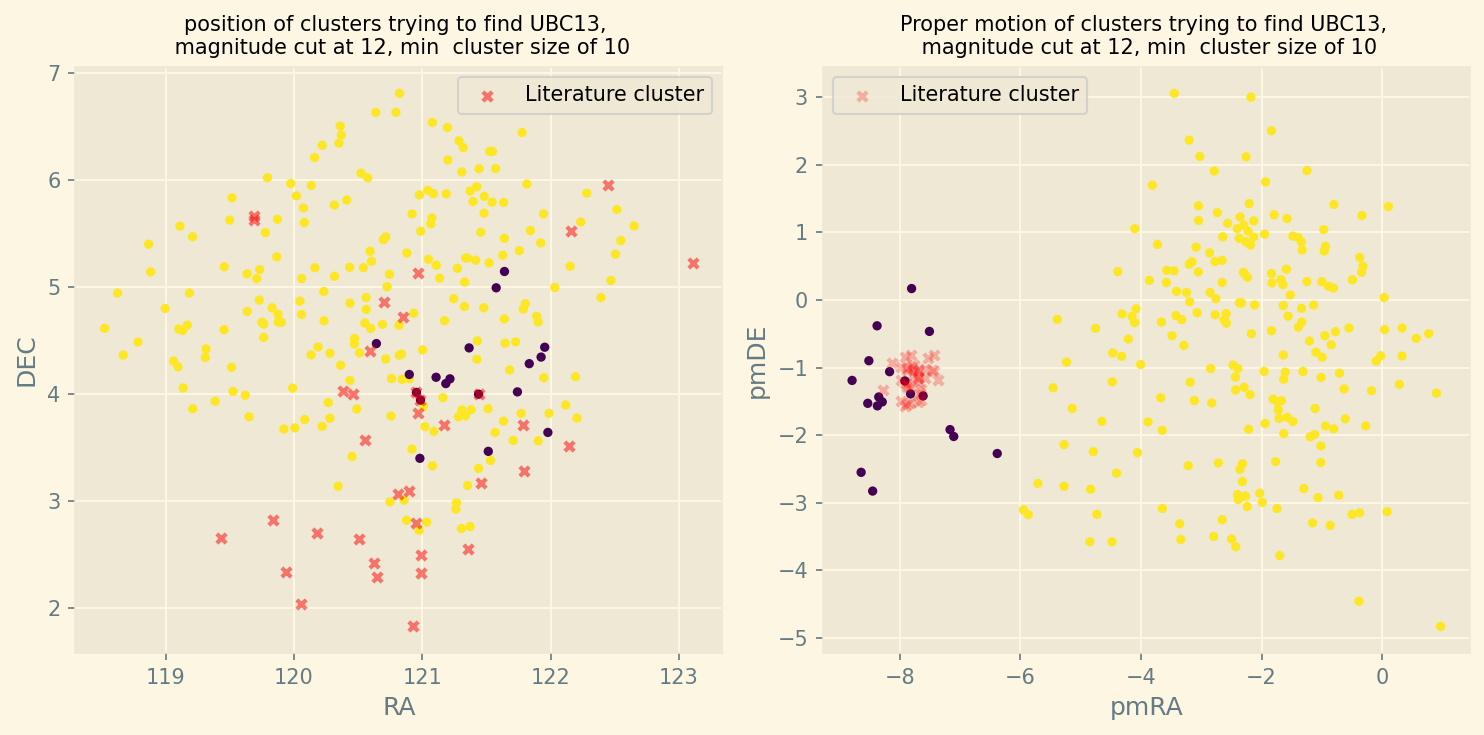

In [19]:
#plot the positions and proper motions of the clusters
indices_to_keep = np.where(UBC13_clusters_mag12.labels_ != -1)[0]
UBC13_clusters_mag12_isolated = UBC13needed.iloc[indices_to_keep]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13_clusters_mag12_isolated['ra'], UBC13_clusters_mag12_isolated['dec'], s=20, linewidth=0, c=UBC13_clusters_mag12.labels_[indices_to_keep])
axs[0].scatter(UBC13members['RAdeg'], UBC13members['DEdeg'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
axs[0].set_title('position of clusters trying to find UBC13, \n magnitude cut at 12, min  cluster size of 10', fontsize = 10)
axs[0].legend()
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

# Second subplot
axs[1].scatter(UBC13_clusters_mag12_isolated['pmra'], UBC13_clusters_mag12_isolated['pmdec'], s=20, linewidth=0, c=UBC13_clusters_mag12.labels_[indices_to_keep])
axs[1].scatter(UBC13members['pmRA'], UBC13members['pmDE'],marker= 'x', s=20, c='red', alpha=0.25, label='Literature cluster')
axs[1].set_title('Proper motion of clusters trying to find UBC13, \n magnitude cut at 12, min  cluster size of 10', fontsize=10)
axs[1].legend()
axs[1].set_xlabel('pmRA')
axs[1].set_ylabel('pmDE')

plt.tight_layout()
plt.savefig('Data\\UBC13_clusters_mag12.pdf')
plt.show()


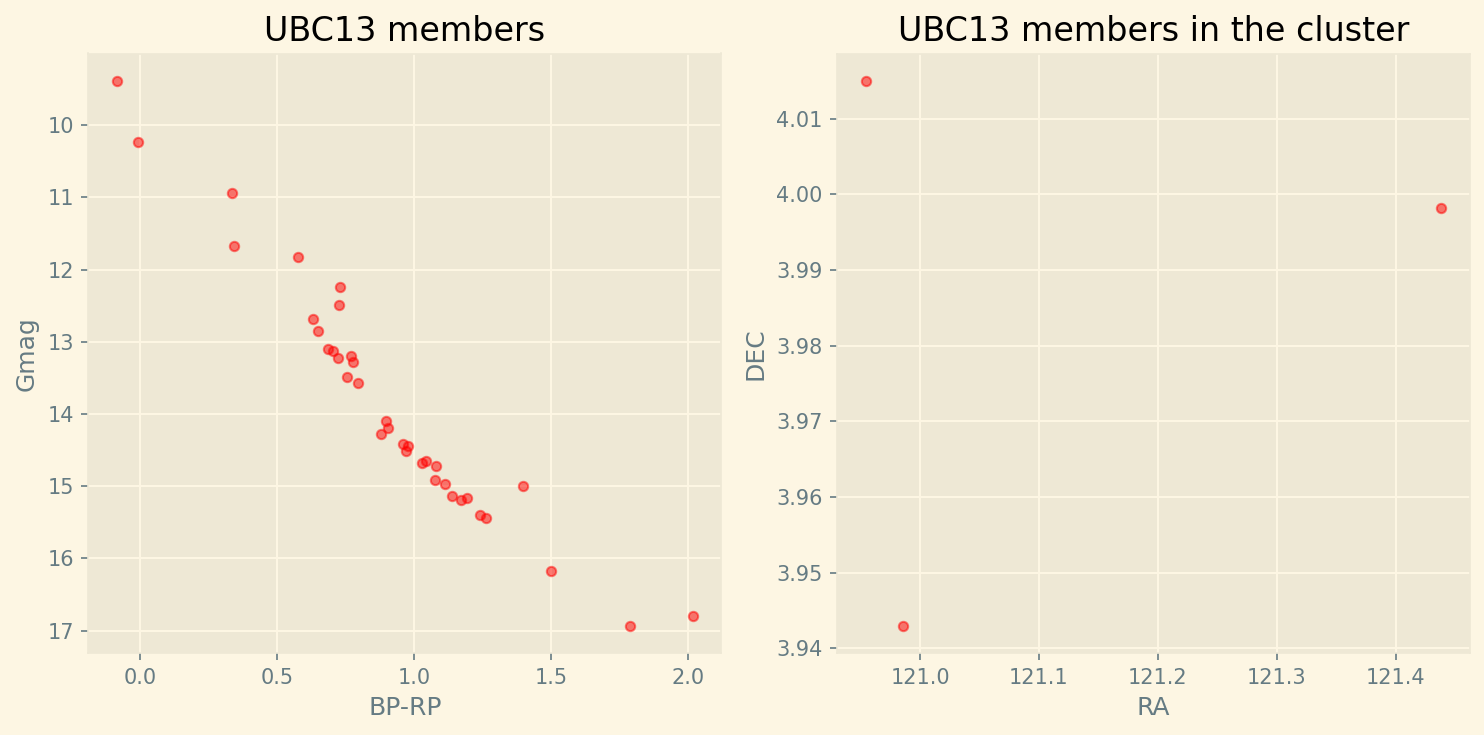

18
for UBC13, with a magnitude cut at 12, the purity is 0.16666666666666666 and the completeness is 0.08333333333333333


In [20]:
#find completeness and purity of the cluster

UBC13_merge_mag12 = pd.merge(UBC13members, UBC13_clusters_mag12_isolated, left_on='Source', right_on='source_id', how='inner')
UBC13_merge_mag12

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13members['BP-RP'], UBC13members['Gmag'], s=20, c='red', alpha=0.5)
axs[0].invert_yaxis()
axs[0].set_title('UBC13 members')
axs[0].set_xlabel('BP-RP')
axs[0].set_ylabel('Gmag')

# Second subplot
axs[1].scatter(UBC13_merge_mag12['ra'], UBC13_merge_mag12['dec'], s=20, c='red', alpha=0.5)
axs[1].set_title('UBC13 members in the cluster')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')

plt.tight_layout()
plt.show()

UBC13_candidates_mag12 = UBC13_clusters_mag12_isolated.query('clusternumber == 0')
print(len(UBC13_candidates_mag12))
UBC13_merge_mag12

UBC13_purity_mag12 = len(UBC13_merge_mag12) / len(UBC13_candidates_mag12)
UBC13_completeness_mag12 = len(UBC13_merge_mag12) / len(UBC13members)

print(f'for UBC13, with a magnitude cut at 12, the purity is {UBC13_purity_mag12} and the completeness is {UBC13_completeness_mag12}')




Now i will do the same thing for no magnitude cut as i dont have time to slowely increase the cut before the presentation.

In [21]:
#cluster the data
UBC13needed = UBC13data[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']]
UBC13needed = UBC13needed.dropna()

UBC13_cluster_prep = UBC13needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]


UBC13_clusters = hdbscan.HDBSCAN(min_cluster_size=20, cluster_selection_method='leaf', min_samples=10).fit(UBC13_cluster_prep)

print(UBC13_clusters.labels_.max() + 1)

UBC13needed['clusternumber'] = UBC13_clusters.labels_ # add the cluster number to the dataframe

41


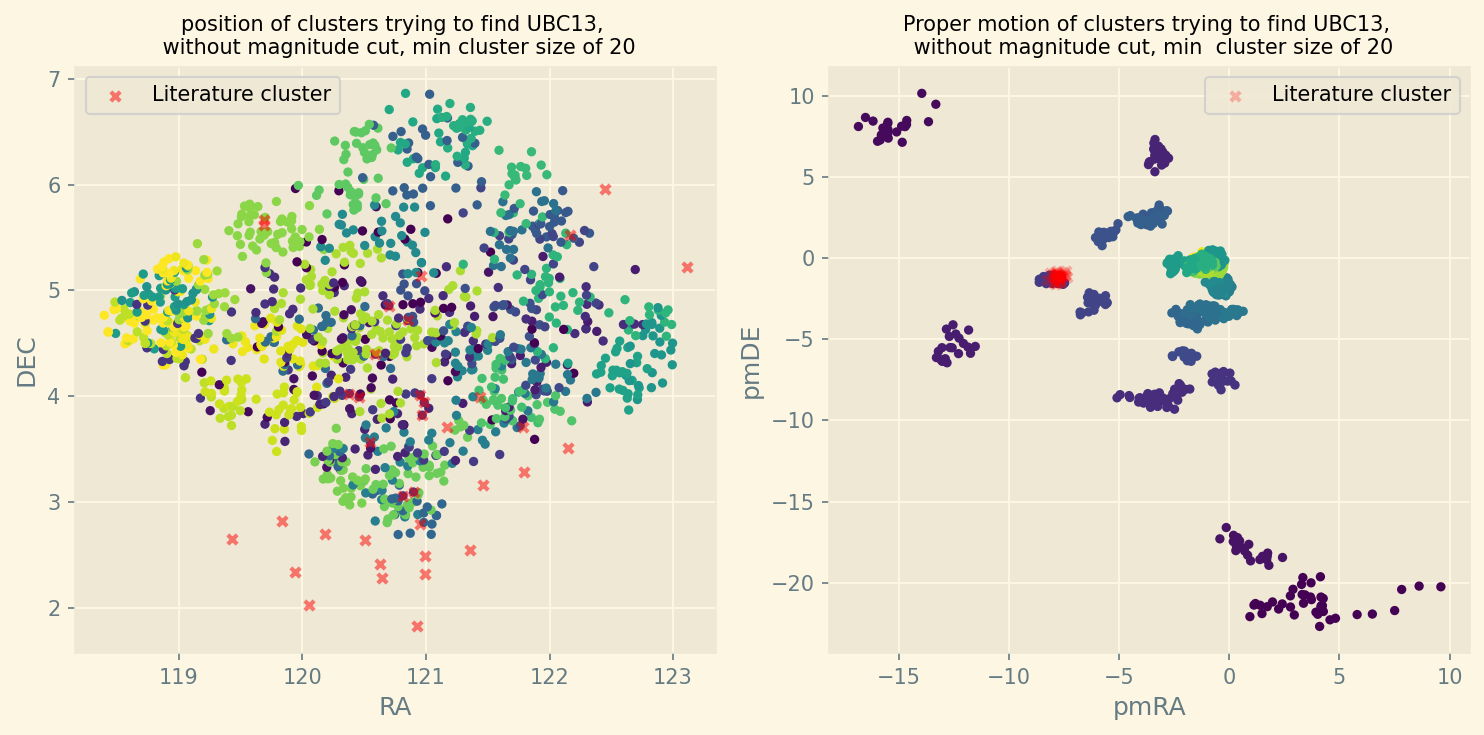

In [22]:
#plot the positions and proper motions of the clusters
indices_to_keep = np.where(UBC13_clusters.labels_ != -1)[0]
UBC13_clusters_isolated = UBC13needed.iloc[indices_to_keep]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13_clusters_isolated['ra'], UBC13_clusters_isolated['dec'], s=20, linewidth=0, c=UBC13_clusters.labels_[indices_to_keep])
axs[0].scatter(UBC13members['RAdeg'], UBC13members['DEdeg'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
axs[0].set_title('position of clusters trying to find UBC13, \n without magnitude cut, min cluster size of 20', fontsize = 10)
axs[0].legend()
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

# Second subplot
axs[1].scatter(UBC13_clusters_isolated['pmra'], UBC13_clusters_isolated['pmdec'], s=20, linewidth=0, c=UBC13_clusters.labels_[indices_to_keep])
axs[1].scatter(UBC13members['pmRA'], UBC13members['pmDE'],marker= 'x', s=20, c='red', alpha=0.25, label='Literature cluster')
axs[1].set_title('Proper motion of clusters trying to find UBC13, \n without magnitude cut, min cluster size of 20', fontsize=10)
axs[1].legend()
axs[1].set_xlabel('pmRA')
axs[1].set_ylabel('pmDE')

plt.tight_layout()
plt.savefig('Data\\UBC13_clusters.pdf')
plt.show()


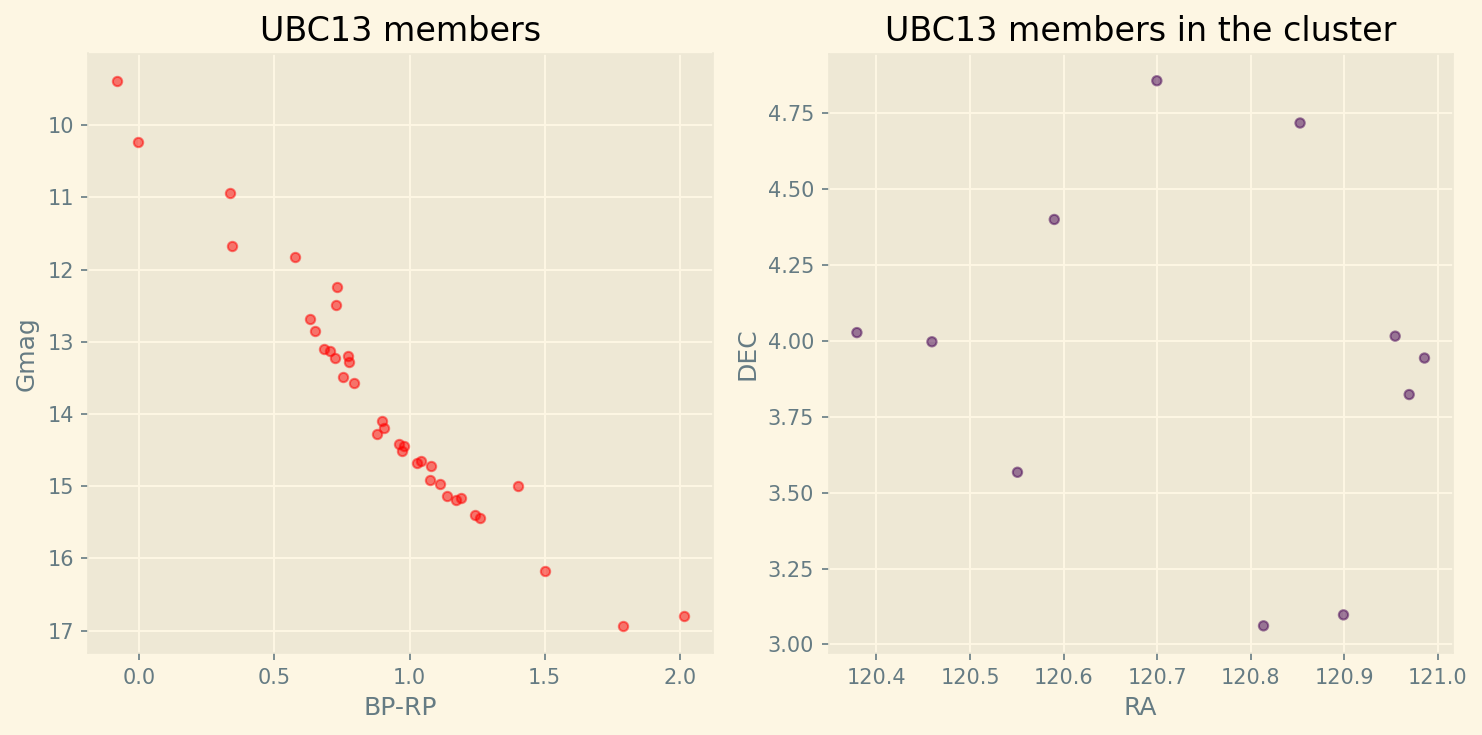

40
for UBC13, without a magnitude cut, the purity is 0.275 and the completeness is 0.3055555555555556


-1

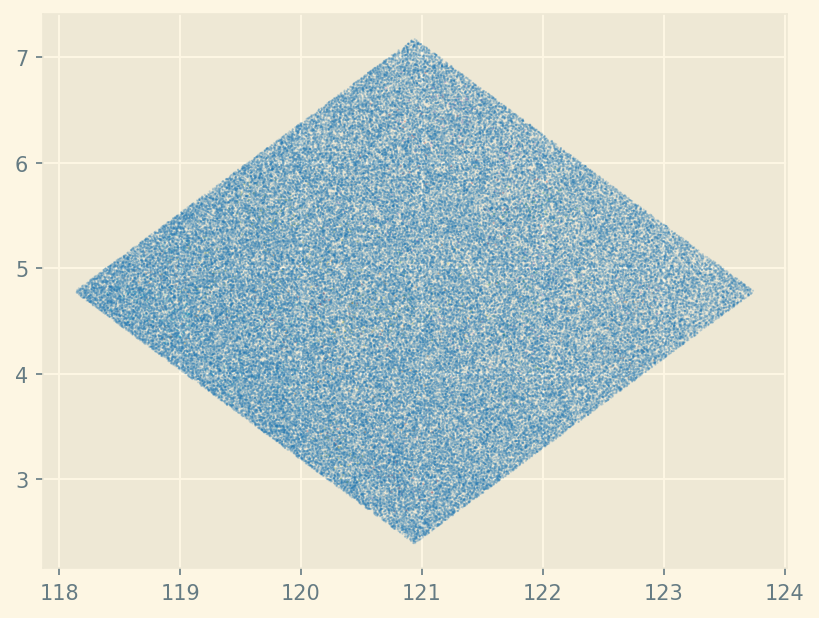

In [43]:
#find completeness and purity of the cluster

UBC13_merge = pd.merge(UBC13members, UBC13_clusters_isolated, left_on='Source', right_on='source_id', how='inner')
UBC13_merge

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot
axs[0].scatter(UBC13members['BP-RP'], UBC13members['Gmag'], s=20, c='red', alpha=0.5)
axs[0].invert_yaxis()
axs[0].set_title('UBC13 members')
axs[0].set_xlabel('BP-RP')
axs[0].set_ylabel('Gmag')

# Second subplot
axs[1].scatter(UBC13_merge['ra'], UBC13_merge['dec'], s=20, c= UBC13_merge['clusternumber'], alpha=0.5)
axs[1].set_title('UBC13 members in the cluster')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')

plt.tight_layout()
plt.show()

UBC13_candidates = UBC13_clusters_isolated.query('clusternumber == 0')
print(len(UBC13_candidates))
UBC13_merge

UBC13_purity = len(UBC13_merge) / len(UBC13_candidates)
UBC13_completeness = len(UBC13_merge) / len(UBC13members)

print(f'for UBC13, without a magnitude cut, the purity is {UBC13_purity} and the completeness is {UBC13_completeness}')

plt.scatter(UBC13needed['ra'], UBC13needed['dec'], s=1, alpha=0.25, linewidth = 0, c=UBC13needed['clusternumber'], cmap='tab10')
UBC13needed['clusternumber'].unique()

Now I will put all of this into a function


In [82]:
def HDBSCAN(data, minsize, magnitudecut):
    data = data[data['phot_g_mean_mag'] <= magnitudecut]
    data_needed = data[['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'source_id']].dropna()
    HDBprep = data_needed[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=minsize, cluster_selection_method='leaf', min_samples=10).fit(HDBprep)
    data_needed['clusternumber'] = clusterer.labels_
    clusteramount = clusterer.labels_.max() + 1
    print(f'HDBScan found {clusteramount} clusters.')
    return data_needed, clusterer


In [83]:
def Clusteranalysis(data_needed,clusterer , literaturecluster, clustername, magnitudecut, minclustersize, savename):
    indices_to_keep = np.where(clusterer.labels_ != -1)[0] # find the indices of the clusters that are not noise
    isolatedclusters = data_needed.iloc[indices_to_keep] # change to the correct dataframe

    #plot the positions and proper motions of the clusters
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First subplot
    axs[0].scatter(isolatedclusters['ra'], isolatedclusters['dec'], s=20, linewidth=0, c=clusterer.labels_[indices_to_keep])
    axs[0].scatter(literaturecluster['RAdeg'], literaturecluster['DEdeg'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
    axs[0].set_title(f'position of clusters trying to find {clustername}, \n with magnitude cut G = {magnitudecut}, min cluster size of {minclustersize}', fontsize = 10)
    axs[0].legend()
    axs[0].set_xlabel('RA')
    axs[0].set_ylabel('DEC')

    # Second subplot
    axs[1].scatter(isolatedclusters['pmra'], isolatedclusters['pmdec'], s=20, linewidth=0, c=clusterer.labels_[indices_to_keep])
    axs[1].scatter(literaturecluster['pmRA'], literaturecluster['pmDE'],marker= 'x', s=20, c='red', alpha=0.5, label='Literature cluster')
    axs[1].set_title(f'Proper motion of clusters trying to find {clustername}, \n with magnitude cut G = {magnitudecut}, min cluster size of {minclustersize}', fontsize=10)
    axs[1].legend()
    axs[1].set_xlabel('pmRA')
    axs[1].set_ylabel('pmDE')

    plt.tight_layout()
    plt.savefig(f'Data\\{savename}.pdf')
    plt.show()

    #find completeness and purity of the cluster
    merge = pd.merge(literaturecluster, isolatedclusters, left_on='Source', right_on='source_id', how='inner') # merge the literature cluster with the clustered dataset on common source id to see which stars coincide
    print(f"The crossmatch finds {len(merge)} matches in cluster(s) {merge['clusternumber'].unique()}.")

    #plot the CMD and position of stars in the cluster matched with the dataset
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First subplot
    axs[0].scatter(UBC13members['BP-RP'], UBC13members['Gmag'], s=20, c='red', alpha=0.5)
    axs[0].invert_yaxis()
    axs[0].set_title('UBC13 members')
    axs[0].set_xlabel('BP-RP')
    axs[0].set_ylabel('Gmag')

    # Second subplot
    axs[1].scatter(merge['ra'], merge['dec'], s=20, c='red', alpha=0.5)
    axs[1].set_title('UBC13 members in the cluster')
    axs[1].set_xlabel('RA')
    axs[1].set_ylabel('DEC')

    plt.tight_layout()
    plt.show()
    if len(merge['clusternumber'].unique()) > 1:
        print(f'The cluster is assigned to multiple clusters, namely {merge["clusternumber"].unique()}.')
    else:
        unique_cluster = merge["clusternumber"].unique()[0]
        candidates = isolatedclusters.query(f'clusternumber == {unique_cluster}') # get all the stars in the clustered dataset that are in the same cluster as the literature cluster
        print(f'The cluster found using HDBSCAN has {len(candidates)} members. The literature cluster has {len(literaturecluster)} members.')

    purity = len(merge) / len(candidates)
    completeness = len(merge) / len(literaturecluster)
    print(f'for {clustername}, with a magnitude cut at {magnitudecut}, the purity is {purity} and the completeness is {completeness}')
    



HDBScan found 9 clusters.


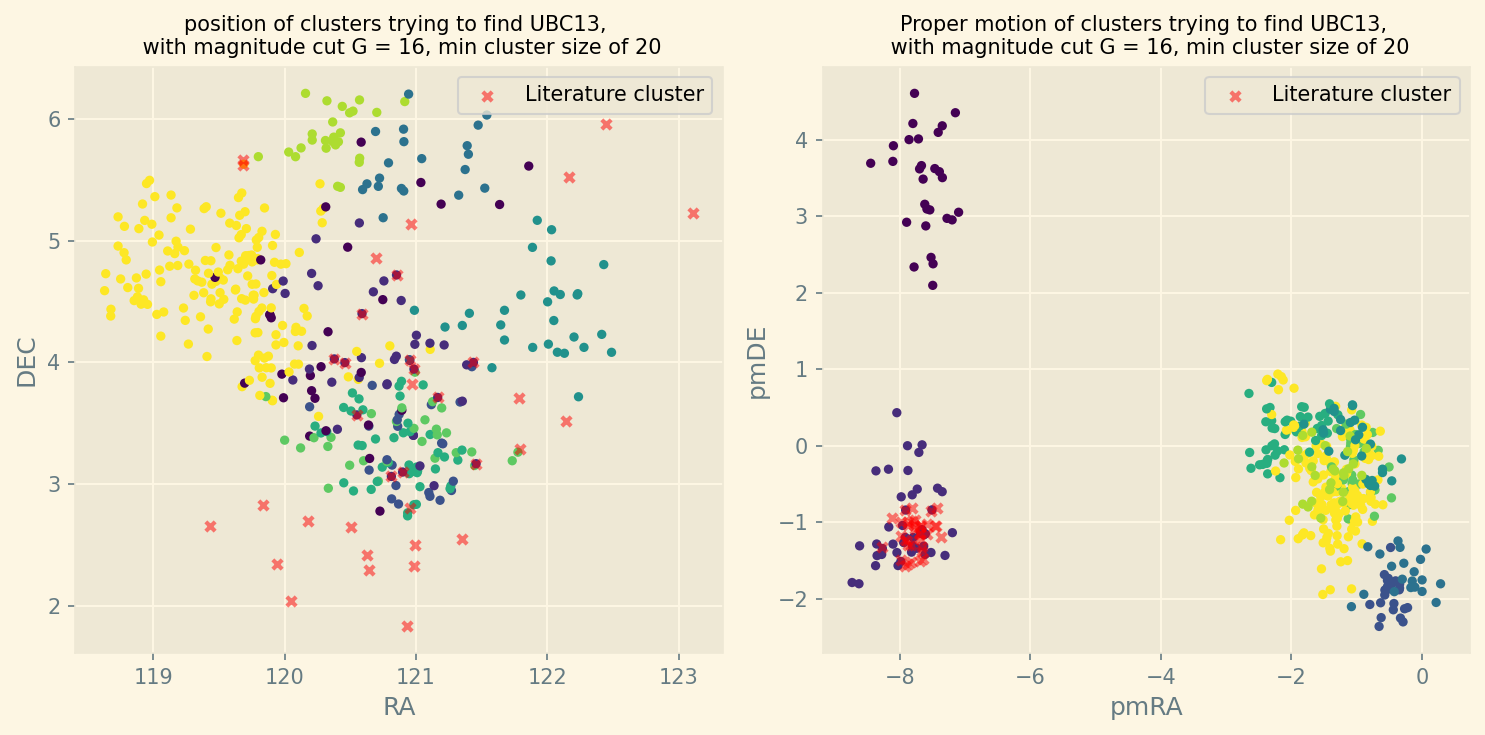

The crossmatch finds 12 matches in cluster(s) [1].


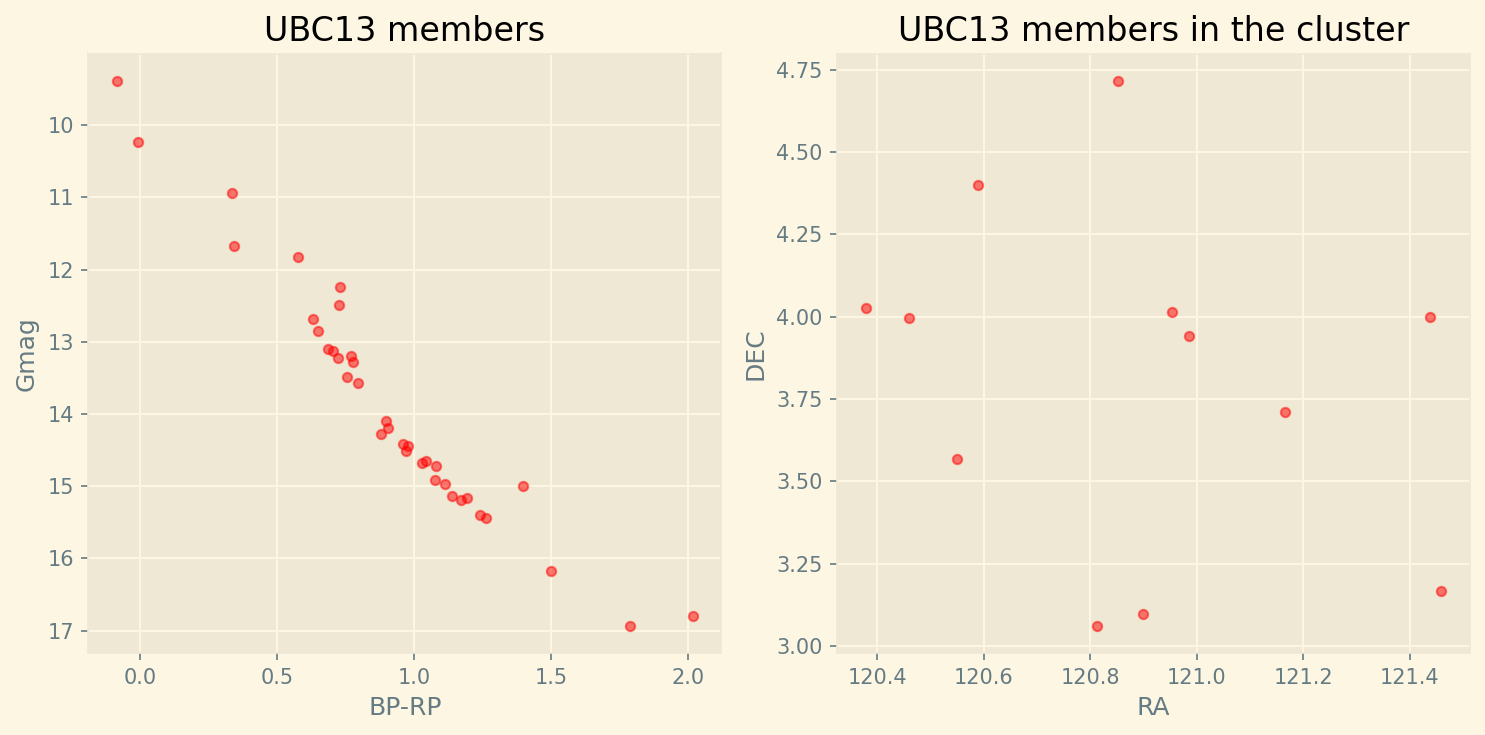

The cluster found using HDBSCAN has 43 members. The literature cluster has 36 members.
for UBC13, with a magnitude cut at 16, the purity is 0.27906976744186046 and the completeness is 0.3333333333333333


In [92]:
UBC13_mag13_needed, UBC13_mag13_clusterer = HDBSCAN(UBC13data, 20, 16)

Clusteranalysis(UBC13_mag13_needed, UBC13_mag13_clusterer, UBC13members, 'UBC13', 16, 20, 'UBC13_clusters_mag16')
